#Для загрузки и обработки тестовых данных

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

import re

def preprocess_text(text):
    text = re.sub(r'[\"\']', '', text)
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())

    return text

#ruT5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
import pandas as pd
from tqdm.notebook import tqdm
import time

Задаём устройство, на котором будем происходить обучение модели:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Класс для передачи данных в dataloader:

In [ ]:
class SentencePairDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=200):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence1 = self.data.iloc[idx, 0]
        sentence2 = self.data.iloc[idx, 1]

        inputs1 = self.tokenizer(sentence1, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs2 = self.tokenizer(sentence2, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'input_ids1': inputs1['input_ids'].squeeze(),
            'attention_mask1': inputs1['attention_mask'].squeeze(),
            'input_ids2': inputs2['input_ids'].squeeze(),
            'attention_mask2': inputs2['attention_mask'].squeeze()
        }

Модель на основе Т5, которая выдаёт эмбеддинг как вывод декодера для токена < pad >:

In [ ]:
class SentenceEmbeddingModelT5(nn.Module):
    def __init__(self, model_name, projection_dim=200):
        super(SentenceEmbeddingModelT5, self).__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.projection = nn.Linear(self.model.encoder.config.d_model, projection_dim)

    def forward(self, input_ids, attention_mask):
        encoder_outputs = self.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # со строками в комментариях ниже лосс сходится, но его значения около 0.9
        #pad_input_ids = tokenizer('<pad>', return_tensors='pt').input_ids
        #decoder_input_ids = pad_input_ids.expand(encoder_outputs.last_hidden_state.size(0), -1).to(device)
        # со строкой ниже лосс расходится, стремится от примерно 0.98 к 1
        decoder_input_ids = torch.zeros((input_ids.shape[0], 1), dtype=torch.long).to(device)
        decoder_outputs = self.model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_outputs.last_hidden_state)
        start_symbol_embedding = decoder_outputs.last_hidden_state[:, 0, :]
        embedding = self.projection(start_symbol_embedding)
        embedding = F.normalize(embedding, p=2, dim=1)

        return embedding

    def get_embedding(self, input_text):
        encoded_input = tokenizer(input_text, truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        input_ids = encoded_input.input_ids.to(device)
        attention_mask = encoded_input.attention_mask.to(device)
        embedding = self.forward(input_ids, attention_mask)

        return embedding

Loss-функция:

In [ ]:
def clip_loss(scores, labels):
      labels = labels.to(torch.float32)

      loss_a = nn.CrossEntropyLoss()
      a = loss_a(scores, labels / torch.sum(labels, dim=0))

      scores = scores.transpose(0, 1)
      labels = labels.transpose(0, 1)

      loss_b = nn.CrossEntropyLoss()
      b = loss_b(scores, labels / torch.sum(labels, dim=0))

      return (a + b) / 2

Создаём экземпляры модели, токенизатора и оптимизатора:

In [ ]:
optimizer = AdamW(t5_model.parameters(), lr=0.00005)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-small')

In [ ]:
model = SentenceEmbeddingModelT5('cointegrated/rut5-small')
tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-small')
optimizer = AdamW(model.parameters(), lr=0.00005)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/259M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/640k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Подгружаем данные и передаём их в dataloader:

In [ ]:
train_dataset = SentencePairDataset('/content/drive/MyDrive/texts_paraphrasers.csv', tokenizer, 40)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)

In [ ]:
SCALE = 20

Функция для обучения модели:

In [ ]:
def train_model(model, dataloader, optimizer, num_epochs):
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0
        for batch in tqdm(dataloader):
            optimizer.zero_grad()

            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)

            embeddings1 = model(input_ids1, attention_mask1)
            embeddings2 = model(input_ids2, attention_mask2)

            #loss = inbatch_sampled_softmax(embeddings1, embeddings2)

            scores = (torch.mm(embeddings1, embeddings2.transpose(0, 1)) * SCALE).to(device)
            labels = torch.eye(input_ids1.size()[0], dtype=torch.bool).to(device)

            loss = clip_loss(scores, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}, 'Затраченное время: {elapsed_time}")

In [ ]:
t5_model.to(device)

SentenceEmbeddingModelT5(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(20100, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(20100, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_

#ruBERT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AdamW
import pandas as pd
from tqdm.notebook import tqdm
import time

Задаём устройство, на котором будем происходить обучение модели:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Класс для передачи данных в dataloader:

In [ ]:
class SentencePairDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=200):
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence1 = self.data.iloc[idx, 0]
        sentence2 = self.data.iloc[idx, 1]

        inputs1 = self.tokenizer(sentence1, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs2 = self.tokenizer(sentence2, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'input_ids1': inputs1['input_ids'].squeeze(),
            'attention_mask1': inputs1['attention_mask'].squeeze(),
            'input_ids2': inputs2['input_ids'].squeeze(),
            'attention_mask2': inputs2['attention_mask'].squeeze()
        }

Модель на основе ruBERT, которая выдаёт эмбеддинг текста как среднее от эмбеддингов всех токенов:

In [ ]:
class SentenceEmbeddingModelBERT(nn.Module):
    def __init__(self, model_name):
        super(SentenceEmbeddingModelBERT, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        avg_embedding = torch.mean(last_hidden_states, dim=1)
        embedding = F.normalize(avg_embedding, p=2, dim=1)

        return embedding

    def get_embedding(self, input):
        encoded_input = tokenizer(input, truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        input_ids = encoded_input.input_ids.to(device)
        attention_mask = encoded_input.attention_mask.to(device)
        embedding = self.forward(input_ids, attention_mask)

        return embedding

Loss-функция:

In [ ]:
def clip_loss(scores, labels):
      labels = labels.to(torch.float32)

      loss_cross = nn.CrossEntropyLoss()
      a = loss_cross(scores, labels / torch.sum(labels, dim=0))

      scores = scores.transpose(0, 1)
      labels = labels.transpose(0, 1)

      b = loss_cross(scores, labels / torch.sum(labels, dim=0))

      return (a + b) / 2

Создаём экземпляры модели, токенизатора и оптимизатора:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
optimizer = AdamW(b_model.parameters(), lr=0.00005)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model = SentenceEmbeddingModelBERT('cointegrated/rubert-tiny2')
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
optimizer = AdamW(model.parameters(), lr=0.00005)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Подгружаем данные и передаём их в dataloader:

In [ ]:
train_dataset = SentencePairDataset('/content/drive/MyDrive/texts_paraphrasers.csv', tokenizer, 40)
train_dataloader = DataLoader(train_dataset, batch_size=300, shuffle=True)

In [ ]:
SCALE = 20

Функция для обучения модели:

In [ ]:
def train_model(model, dataloader, optimizer, num_epochs):
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0
        for batch in tqdm(dataloader):
            optimizer.zero_grad()

            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)

            embeddings1 = model(input_ids1, attention_mask1)
            embeddings2 = model(input_ids2, attention_mask2)

            #loss = inbatch_sampled_softmax(embeddings1, embeddings2)

            scores = (torch.mm(embeddings1, embeddings2.transpose(0, 1)) * SCALE).to(device)
            labels = torch.eye(input_ids1.size()[0], dtype=torch.bool).to(device)

            loss = clip_loss(scores, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}, 'Затраченное время: {elapsed_time}")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_bert_5.pth')

#Обучение модели

In [ ]:
num_epochs = 1
train_model(b_model, train_dataloader, optimizer, num_epochs)

  0%|          | 0/2069 [00:00<?, ?it/s]

Эпоха 1/1, Loss: 0.24713335177960633, 'Затраченное время: 520.1109516620636


In [ ]:
torch.save({
            'epoch': 11,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, 'trained_model_t5_11.pth')

In [ ]:
torch.cuda.empty_cache()

#Вычисление метрик для части обучающей выборки

##Загружаем и предобрабатываем тестовый датасет

---



In [ ]:
test_size = 1000

###matreshka

In [ ]:
dataset_matreshka1 = load_dataset("zjkarina/matreshka", split="validation")

Generating train split:   0%|          | 0/6655 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1664 [00:00<?, ? examples/s]

In [ ]:
matreshka_text = []

for i in range(test_size):
    text1 = dataset_matreshka1[i]['summary']
    text2 = dataset_matreshka1[i]['dialog']
    if (isinstance(text1, str) and text2 != None):
        text2 = ' '.join(text2)
        if (len(text2.split()) <= 1000):
            sentence1 = preprocess_text(text1)
            sentence2 = preprocess_text(text2)
            matreshka_text.append((sentence1, sentence2))

###ru_paraphraser

In [ ]:
dataset_ru_par = load_dataset("merionum/ru_paraphraser", split="test")

Generating train split:   0%|          | 0/7227 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
dataset_ru_par_size = len(dataset_ru_par)

ru_par_text = []

for i in range(dataset_ru_par_size):
    if dataset_ru_par[i]['class'] == '1':
        sentence1 = preprocess_text(dataset_ru_par[i]['text_1'])
        sentence2 = preprocess_text(dataset_ru_par[i]['text_2'])
        ru_par_text.append((sentence1, sentence2))

In [ ]:
len(ru_par_text)

374

###stsb-multi

In [ ]:
dataset_stsb = load_dataset("stsb_multi_mt", name="ru", split="test")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
dataset_stsb_size = len(dataset_stsb)

stsb_text = []

for i in range(dataset_stsb_size):
    if dataset_stsb[i]['similarity_score'] >= 3.5:
        sentence1 = preprocess_text(dataset_stsb[i]['sentence1'])
        sentence2 = preprocess_text(dataset_stsb[i]['sentence2'])
        stsb_text.append((sentence1, sentence2))

In [ ]:
len(stsb_text)

479

##Вычисляем эмбеддинги и метрики

In [ ]:
test_data = pd.DataFrame(matreshka_text, columns=['text1', 'text2'])
#test_data = pd.DataFrame(ru_par_text, columns=['text1', 'text2'])

In [ ]:
test_text_embedding1 = []
test_text_embedding2 = []

elapsed_time = 0

#test_size = len(ru_par_text)

for i in range(test_size):
    text1 = test_data.iloc[i]['text1']
    text2 = test_data.iloc[i]['text2']

    start_time = time.time()

    embedding1 = t5_model.get_embedding(text1).squeeze().to(device)

    end_time = time.time()
    elapsed_time += end_time - start_time

    embedding2 = t5_model.get_embedding(text2).squeeze().to(device)
    test_text_embedding1.append(embedding1.cpu().detach().numpy())
    test_text_embedding2.append(embedding2.cpu().detach().numpy())

print(f'Среднее время на вычисление одного эмбеддинга: {elapsed_time / test_size}')

test_data['embedding1'] = test_text_embedding1
test_data['embedding2'] = test_text_embedding2

Среднее время на вычисление одного эмбеддинга: 0.03262298440933228


In [ ]:
R1 = 0
R5 = 0
R10 = 0
MRR = 0
elapsed_time = 0

for i in range(test_size):
    query_emb = test_data['embedding1'].iloc[i]

    start_time = time.time()

    test_data['sim'] = test_data['embedding2'].apply(lambda x: torch.dot(torch.Tensor(query_emb), torch.Tensor(x)).squeeze().detach().numpy())

    end_time = time.time()
    elapsed_time += (end_time - start_time) / test_size

    test_data['rank_desc'] = test_data['sim'].rank(ascending=False, method='min')
    query_paraphrase_rank = test_data['rank_desc'].iloc[i]
    if query_paraphrase_rank == 1:
      R1 += 1
    if query_paraphrase_rank <= 5:
      R5 += 1
    if query_paraphrase_rank <= 10:
      R10 += 1
    MRR += 1 / query_paraphrase_rank

R1 /= test_size
R5 /= test_size
R10 /= test_size
MRR /= test_size
elapsed_time /= test_size

print(f'R1: {R1}\nR5: {R5}\nR10: {R10}\nMRR: {MRR}\nСреднее время на вычисление подобия двух эмбеддингов: {elapsed_time}')

R1: 0.645
R5: 0.805
R10: 0.856
MRR: 0.7180032213796026
Среднее время на вычисление подобия двух эмбеддингов: 2.2442706346511825e-05


In [ ]:
value_set = [
    [32.8, 44.4, 37.2, 45.6, 44.4, 44.8, 45.2, 38.4, 42.8, 37.6],
    [46.4, 58.8, 54, 63.2, 60, 60.8, 62, 53.6, 60.4, 55.2],
    [84.8, 94.8, 93.2, 95.2, 95.6, 93.6, 94, 92, 95.2, 96],
    [52, 57.2, 56.4, 57.4, 57.6, 56.6, 56.8, 56, 57.4, 58]
]

for i in range(4):
  for j in range(10):
    value_set[i][j] /= 100

[[0.32799999999999996,
  0.444,
  0.37200000000000005,
  0.456,
  0.444,
  0.44799999999999995,
  0.452,
  0.384,
  0.428,
  0.376],
 [0.46399999999999997,
  0.588,
  0.54,
  0.632,
  0.6,
  0.608,
  0.62,
  0.536,
  0.604,
  0.552],
 [0.848,
  0.948,
  0.932,
  0.9520000000000001,
  0.956,
  0.9359999999999999,
  0.94,
  0.92,
  0.9520000000000001,
  0.96],
 [0.52,
  0.5720000000000001,
  0.564,
  0.574,
  0.5760000000000001,
  0.5660000000000001,
  0.568,
  0.56,
  0.574,
  0.58]]

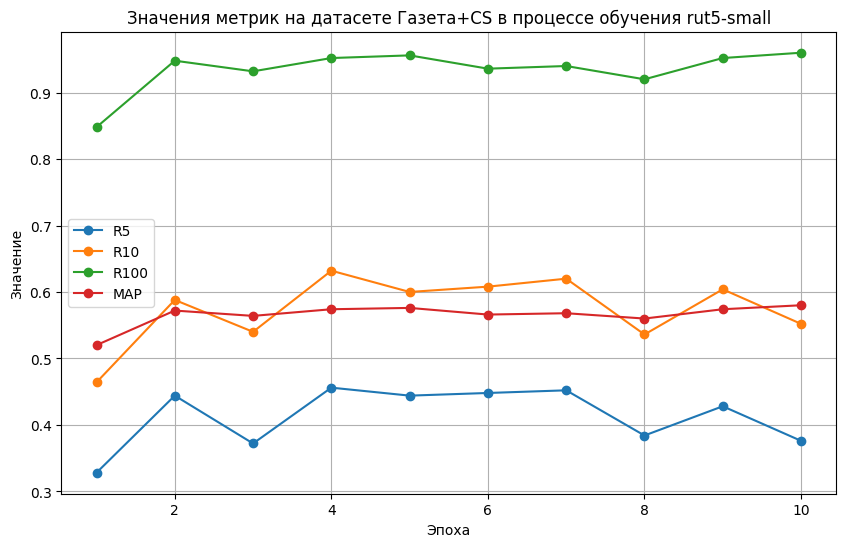

In [ ]:
import matplotlib.pyplot as plt

#value_set = [
#    [0.009, 0.41, 0.491, 0.541, 0.569, 0.559, 0.605, 0.616, 0.632, 0.636],
#    [0.027, 0.676, 0.719, 0.768, 0.776, 0.793, 0.786, 0.808, 0.819, 0.813],
#    [0.047, 0.76, 0.792, 0.833, 0.825, 0.852, 0.85, 0.855, 0.86, 0.864],
#    [0.026, 0.529, 0.595, 0.645, 0.664, 0.662, 0.689, 0.704, 0.719, 0.713]
#]

#value_set = [
#    [0.433, 0.731, 0.763, 0.777, 0.773],
#    [0.586, 0.86, 0.87, 0.882, 0.881],
#    [0.649, 0.892, 0.903, 0.913, 0.912],
#    [0.505, 0.79, 0.813, 0.825, 0.826]
#]


plt.figure(figsize=(10, 6))

plt.plot(range(1, 11), value_set[0], marker='o', label='R5')
plt.plot(range(1, 11), value_set[1], marker='o', label='R10')
plt.plot(range(1, 11), value_set[2], marker='o', label='R100')
plt.plot(range(1, 11), value_set[3], marker='o', label='MAP')

plt.title('Значения метрик на датасете Газета+CS в процессе обучения rut5-small')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

#Вычисление метрик

In [ ]:
test_data = pd.read_csv('test_data.csv', names=['text', 'query_id'])
queries = pd.read_csv('queries.csv')

Вычисляем эмбеддинги для всех текстов в тестовом датасете.

In [ ]:
test_data_size = len(test_data)

text_embedding = []

for i in range(test_data_size):
    text = test_data.iloc[i]['text']
    embedding = model.get_embedding(text).squeeze().to(device)
    text_embedding.append(embedding.cpu().detach().numpy())

test_data['embedding'] = text_embedding

Функция для вычисления метрик.

In [ ]:
def get_metrics_for_query(query_id, data):

    start_time = time.time()

    # вычисляем эмбеддинг для поискового запроса
    query = queries.iloc[query_id]['query']
    query_embedding = model.get_embedding(query).squeeze()

    # копируем датафрейм, чтобы тот, который мы передаём в качестве параметра, не изменялся
    data_for_ranking = data

    # сохраняем в колонку query_text_sim значения косинусного сходства для каждого текста из тестовой выборки и запроса
    text_embeddings = data_for_ranking['embedding'].to_list()
    query_text_similarity = [torch.dot(query_embedding, torch.tensor(text).to(device)).squeeze().cpu().detach().numpy() for text in text_embeddings]
    data_for_ranking['query_text_sim'] = query_text_similarity

    # сохраняем в колонку rank_desc номера текстов при ранжировании их по убыванию значений косинусных сходств
    data_for_ranking['rank_desc'] = data_for_ranking['query_text_sim'].rank(ascending=False, method='min')
    ranks = sorted(data_for_ranking[data_for_ranking['query_id'] == str(int(query_id + 1))]['rank_desc'].to_list())

    reverse_rank_of_first = 1 / ranks[0]

    end_time = time.time()

    # считаем время, затраченное на обработку одного запроса
    elapsed_time = end_time - start_time

    # считаем R-метрики
    R5 = len([x for x in ranks if x <= 5]) / 5 * 100
    R10 = len([x for x in ranks if x <= 10]) / 5 * 100
    R100 = len([x for x in ranks if x <= 100]) / 5 * 100
    R300 = len([x for x in ranks if x <= 300]) / 5 * 100

    # считаем average precision at 100
    R = 0
    count = 0
    for k in range(100):
        if k in ranks:
            R += len([x for x in ranks if x <= k]) / 5 * 100
            count += 1
    average_precision_100 = 0 if count == 0 else R / count

    return [R5, R10, R100, R300, average_precision_100, elapsed_time, reverse_rank_of_first]

Вычисляем метрики для 50 запросов (нумерация от 1 до 50).

In [ ]:
columns = ['R5', 'R10', 'R100', 'R300', 'avp@100', 'elapsed_time']
metrics = pd.DataFrame(columns=columns)

mrr = 0

for i in range(50):
    metrics_for_query = get_metrics_for_query(i, test_data)
    metrics.loc[len(metrics)] = metrics_for_query[:6]
    mrr += metrics_for_query[6]

mrr /= 50

Вычисляем средние значения метрик по всем запросам.

In [ ]:
R5_mean = metrics['R5'].mean()
R10_mean = metrics['R10'].mean()
R100_mean = metrics['R100'].mean()
R300_mean = metrics['R300'].mean()
avp100_mean = metrics['avp@100'].mean()
elapsed_time_mean = metrics['elapsed_time'].mean()

print(f'R5: {R5_mean}% \nR10: {R10_mean}% \nR100: {R100_mean}% \nR300: {R300_mean}% \navp100: {avp100_mean}%\nMRR: {mrr} \nЗатраченное время: {elapsed_time_mean}')

R5: 66.8% 
R10: 82.0% 
R100: 98.0% 
R300: 99.6% 
avp100: 59.0%
MRR: 0.7909198312236286 
Затраченное время: 0.0967543363571167


#Если нужно восстановить сохранённую модель

In [ ]:
model_load_path = "trained_model_t5_11.pth"

# Создание модели и оптимизатора
b_model = SentenceEmbeddingModelT5('cointegrated/rut5-small')

# Загрузка сохраненного состояния
checkpoint = torch.load(model_load_path)

# Восстановление состояния модели и оптимизатора
t5_model.load_state_dict(checkpoint['model_state_dict'])

# Восстановление других параметров
epoch = checkpoint['epoch']

b_model.to(device)

SentenceEmbeddingModelBERT(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12